# Imports

In [19]:
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
from scipy.stats import skew, kurtosis
import pandas as pd

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import accuracy_score, confusion_matrix

PROJECT_ROOT = Path(os.path.abspath(__file__)).parent if '__file__' in globals() else Path.cwd()
DATA_DIR = os.path.join(PROJECT_ROOT, "data")
EMG_DIR = os.path.join(DATA_DIR, "EMG")
OUT_DIR = os.path.join(PROJECT_ROOT, "output")

EMG_OUTPUT_DIR = os.path.join(OUT_DIR, "emg")
os.makedirs(EMG_OUTPUT_DIR, exist_ok=True)

np.random.seed(42)

# Part 1: Single subject classification

## Loading data

In [20]:
s2_dir = Path(EMG_DIR) / 's2'

mat_files = sorted(s2_dir.glob('S2_*.mat'))
print(f'found {len(mat_files)} .mat files for subject 2')
for f in mat_files:
    m = loadmat(f, squeeze_me=True)
    keys = [k for k in m.keys() if not k.startswith('__')]
    print(f'\n{f.name}: keys -> {keys}')
    emg_key = next((k for k in keys if 'emg' in k.lower()), None)
    if emg_key:
        emg = m[emg_key]
        print(f'  {emg_key} shape: {np.shape(emg)}')
    restimulus = m.get('restimulus', None)
    if restimulus is not None:
        rs = np.asarray(restimulus).ravel()
        print(f'  unique stimulus labels: {np.unique(rs)}')
    rerepetition = m.get('rerepetition', None)
    if rerepetition is not None:
        rr = np.asarray(rerepetition).ravel()
        print(f'  repetitions: {np.unique(rr)}')

# Save only exercise 1 for subject 2
s2_dir = Path(EMG_DIR) / 's2'
ex1_file = sorted(s2_dir.glob('S2_A1_E1.mat'))
if not ex1_file:
    raise FileNotFoundError('S2_A1_E1.mat not found under EMG_DIR/s2')
ex1_path = ex1_file[0]
mat_ex1 = loadmat(ex1_path, squeeze_me=True)

subject = np.asarray(mat_ex1.get('subject')) if 'subject' in mat_ex1 else None
exercise = np.asarray(mat_ex1.get('exercise')) if 'exercise' in mat_ex1 else None
stimulus = np.asarray(mat_ex1.get('stimulus')) if 'stimulus' in mat_ex1 else None
restimulus = np.asarray(mat_ex1.get('restimulus')) if 'restimulus' in mat_ex1 else None
repetition = np.asarray(mat_ex1.get('repetition')) if 'repetition' in mat_ex1 else None
rerepetition = np.asarray(mat_ex1.get('rerepetition')) if 'rerepetition' in mat_ex1 else None
emg_ex1 = np.asarray(mat_ex1['emg'])
glove = np.asarray(mat_ex1.get('glove')) if 'glove' in mat_ex1 else None
fs_val = mat_ex1.get('fs', None)
fs_ex1 = float(np.asarray(fs_val).squeeze()) if fs_val is not None else 100.0

out_path = s2_dir / 's2_ex1_raw.npz'
np.savez(
    out_path,
    subject=subject,
    exercise=exercise,
    stimulus=stimulus,
    restimulus=restimulus,
    repetition=repetition,
    rerepetition=rerepetition,
    emg=emg_ex1,
    glove=glove,
    fs=fs_ex1,
)
print(f'\nsaved exercise 1 to {out_path}')

found 3 .mat files for subject 2

S2_A1_E1.mat: keys -> ['subject', 'exercise', 'stimulus', 'emg', 'glove', 'restimulus', 'repetition', 'rerepetition']
  emg shape: (100686, 10)
  unique stimulus labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
  repetitions: [ 0  1  2  3  4  5  6  7  8  9 10]

S2_A1_E2.mat: keys -> ['subject', 'exercise', 'stimulus', 'emg', 'glove', 'restimulus', 'repetition', 'rerepetition']
  emg shape: (142731, 10)
  unique stimulus labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
  repetitions: [ 0  1  2  3  4  5  6  7  8  9 10]

S2_A1_E3.mat: keys -> ['subject', 'exercise', 'stimulus', 'emg', 'glove', 'restimulus', 'repetition', 'rerepetition']
  emg shape: (229084, 10)
  unique stimulus labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
  repetitions: [ 0  1  2  3  4  5  6  7  8  9 10]

saved exercise 1 to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\data\EMG\s2\s2_ex1_raw.npz


### Visualize data before processing

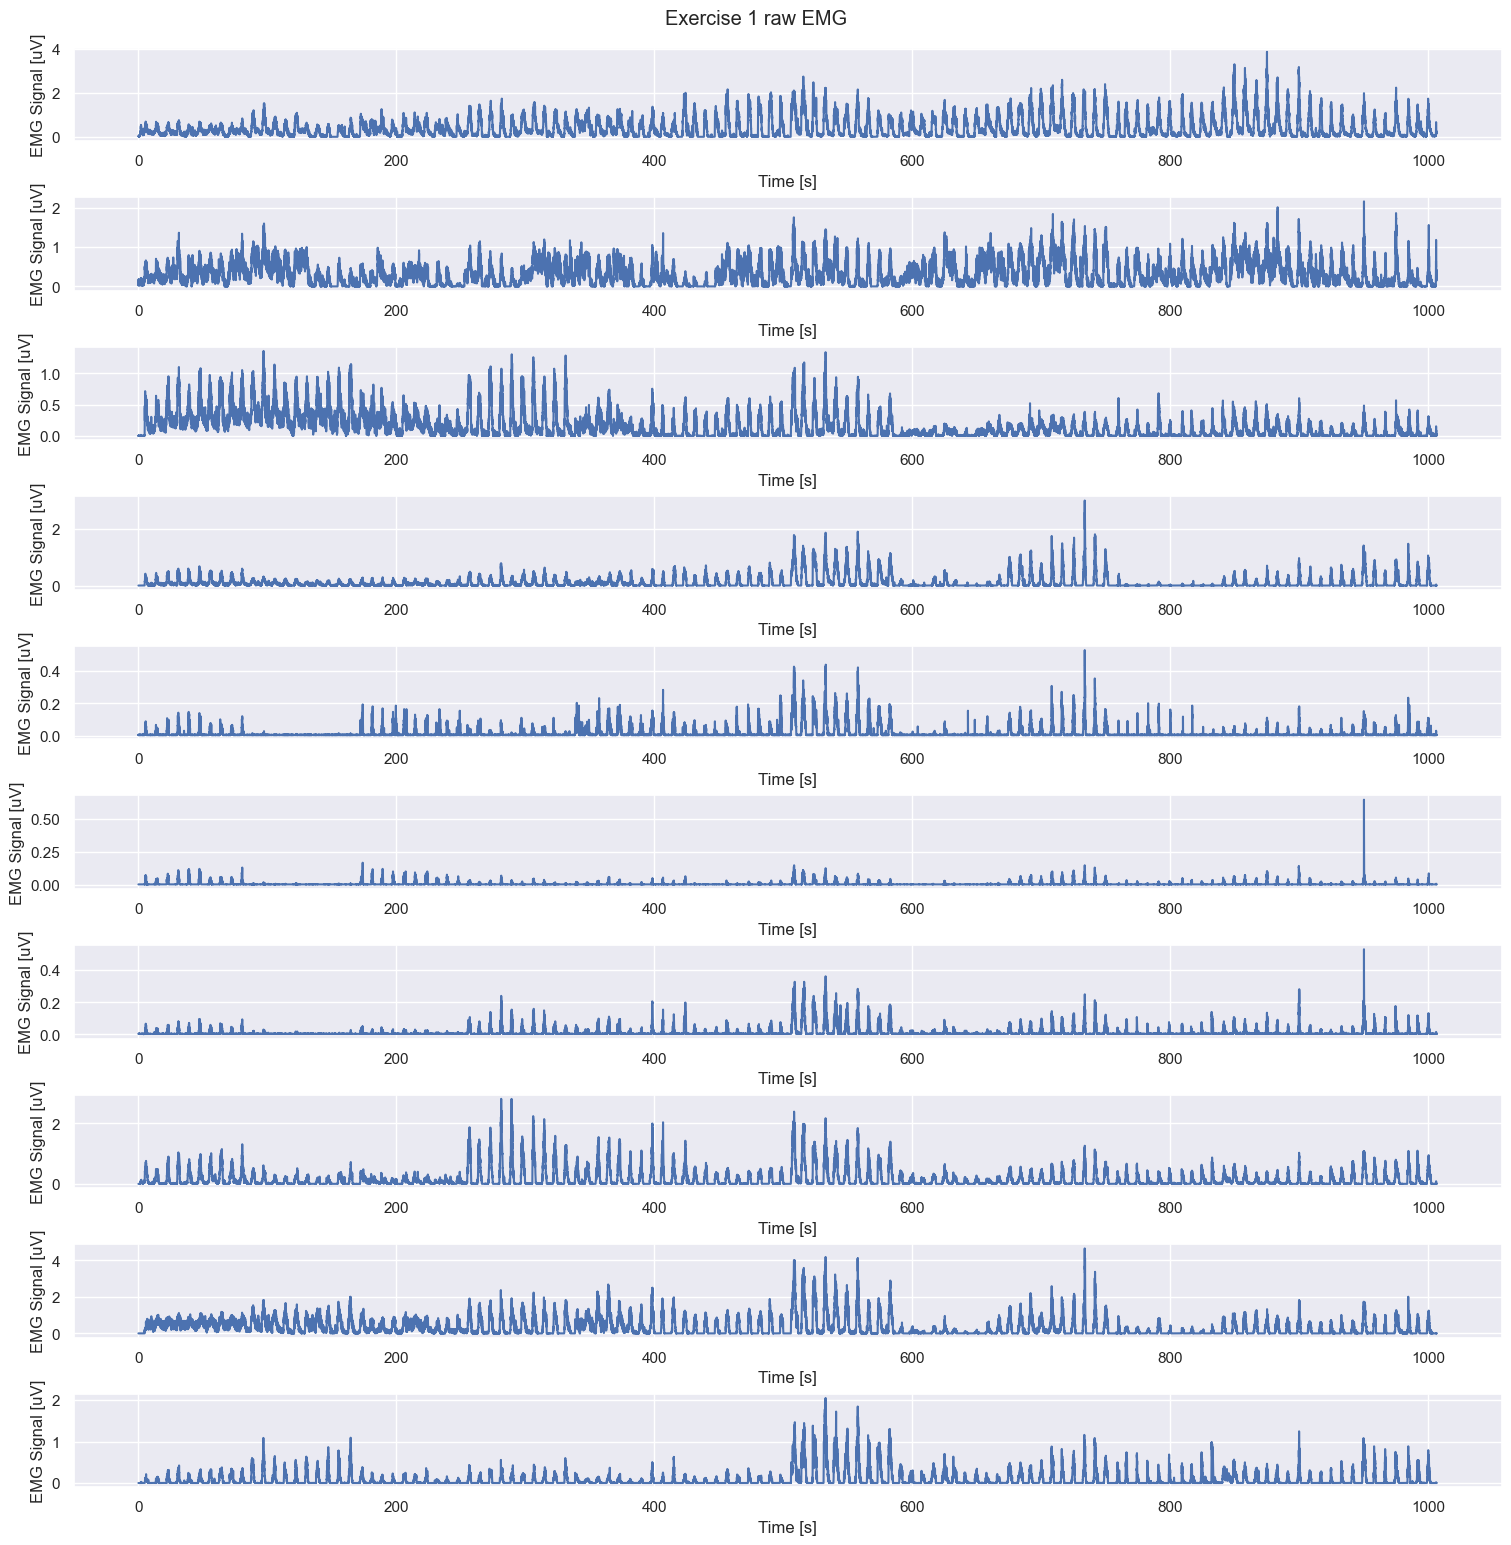

In [21]:
s2_a1_e1_path = Path(EMG_DIR) / 's2' / 's2_ex1_raw.npz'
raw = np.load(s2_a1_e1_path)
emg_raw = raw['emg']
fs = float(raw['fs'])
n_channels = emg_raw.shape[1]
time_steps = np.arange(emg_raw.shape[0]) / fs

fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 15))
for channel_idx in range(n_channels):
    ax[channel_idx].plot(time_steps, emg_raw[:, channel_idx])
    ax[channel_idx].set_xlabel('Time [s]')
    ax[channel_idx].set_ylabel('EMG Signal [uV]')
fig.suptitle('Exercise 1 raw EMG', y=1.02)
plt.show()


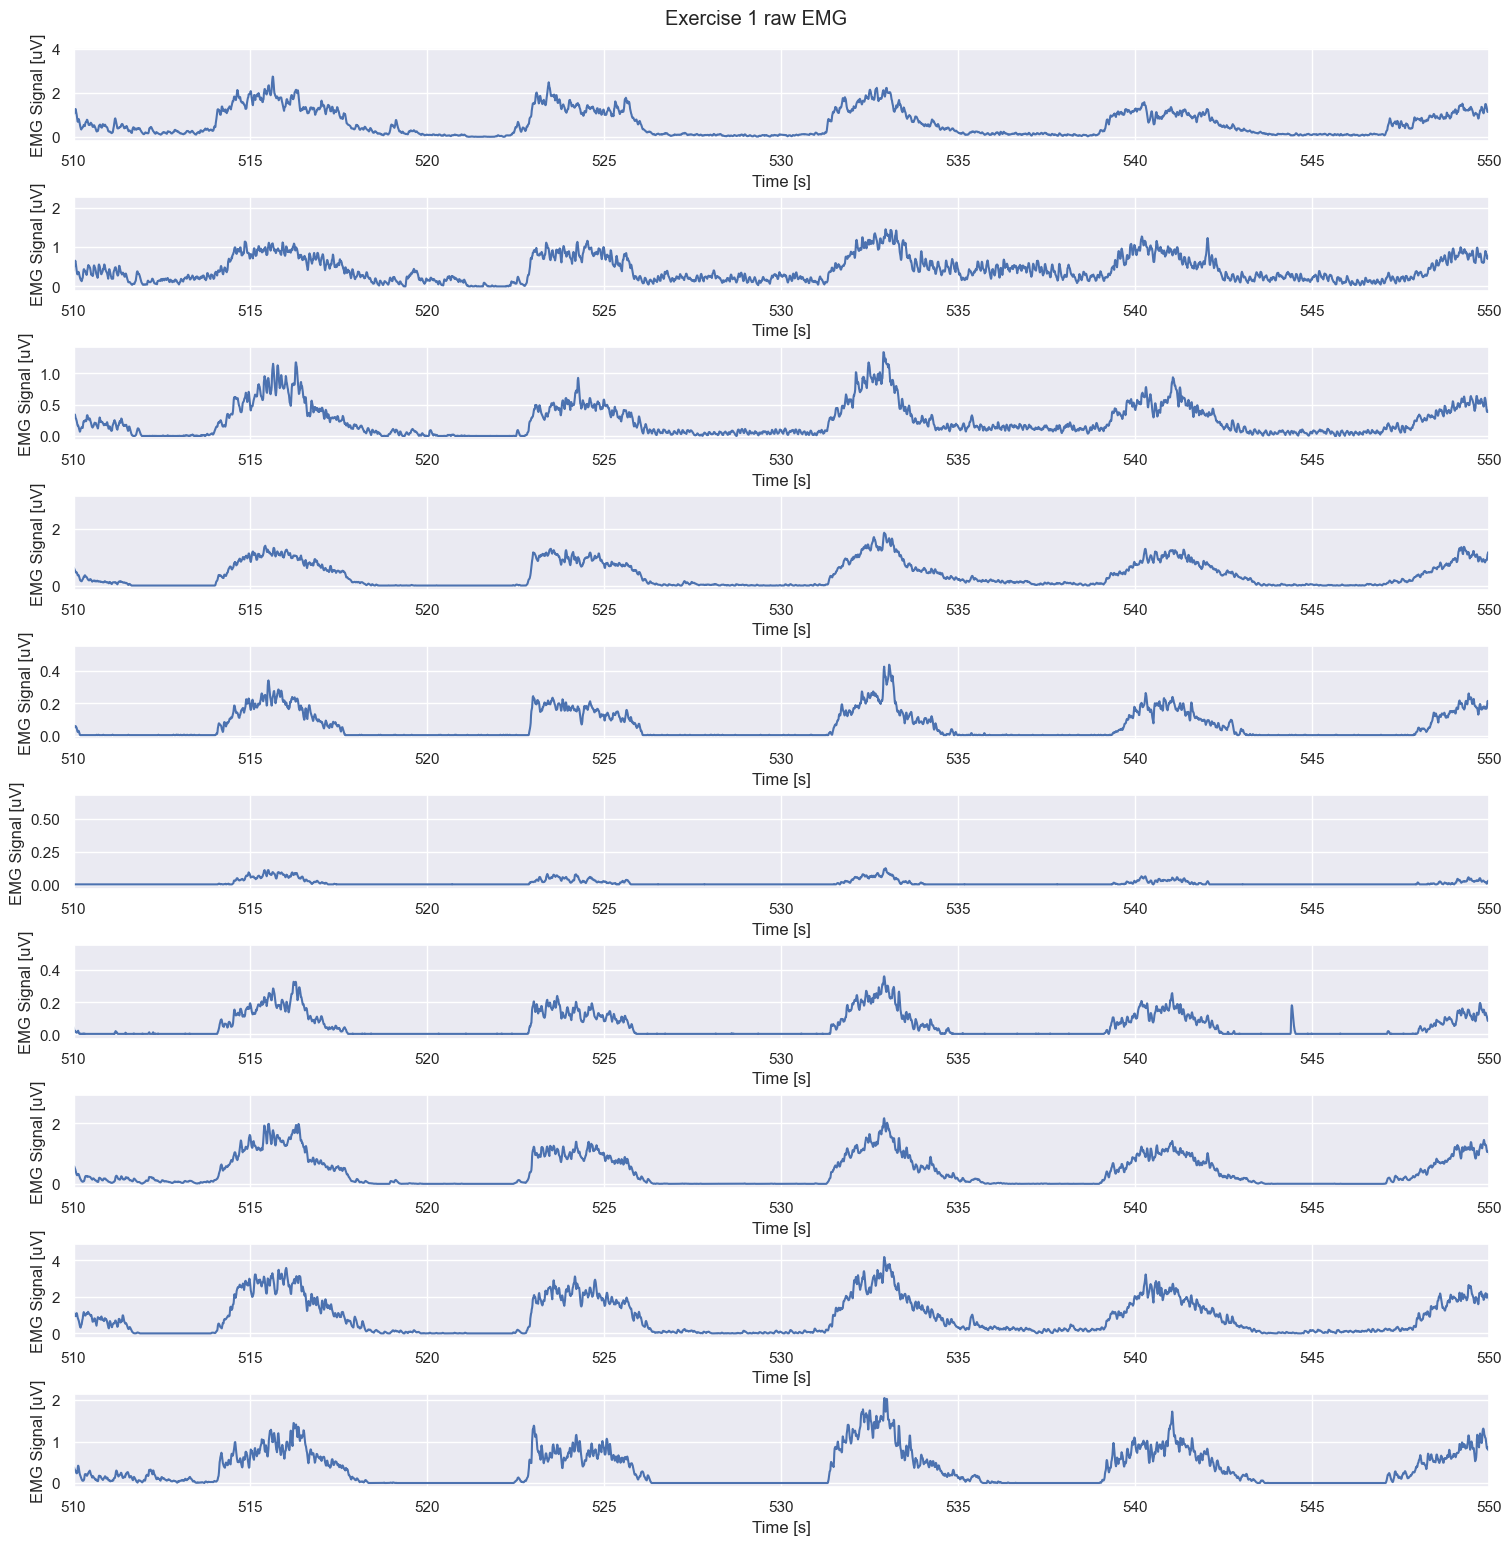

In [22]:
fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 15))
for channel_idx in range(n_channels):
    ax[channel_idx].plot(time_steps, emg_raw[:, channel_idx])
    ax[channel_idx].set_xlim(510, 550)
    ax[channel_idx].set_xlabel('Time [s]')
    ax[channel_idx].set_ylabel('EMG Signal [uV]')
fig.suptitle('Exercise 1 raw EMG', y=1.02)
plt.show()


## Preprocessing

### Low-pass filter at 1Hz to smooth the envelope

From paper: "Before performing the classification, the data from database 1 were preprocessed using a 1st order Butterworth low-pass filter with a 1 Hz cutoff frequency"

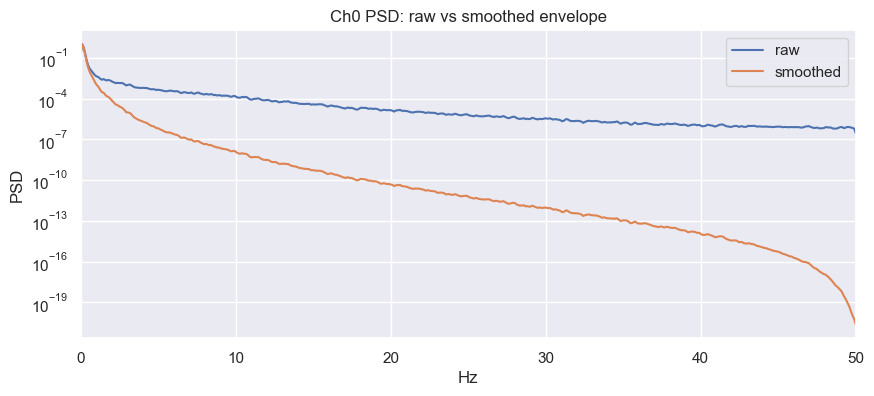

Processed data saved to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\output\emg\s2\s2_ex1_processed.npz


In [23]:
s2_a1_e1_path = Path(EMG_DIR) / 's2' / 's2_ex1_raw.npz'
raw = np.load(s2_a1_e1_path)
emg = raw['emg']
fs = float(raw['fs'])  # This is 100.0
n_channels = emg.shape[1]
time_steps = np.arange(emg.shape[0]) / fs

# plot PSD of raw vs smoothed on one plot
f_raw, pxx_raw = welch(emg[:, 0], fs=fs, nperseg=1024)

sos = butter(N=1, Wn=1, fs=fs, btype='low', output='sos')
emg_filtered = sosfiltfilt(sos, emg.T).T
f_filt, pxx_filt = welch(emg_filtered[:, 0], fs=fs, nperseg=1024)

plt.figure(figsize=(10, 4))
plt.semilogy(f_raw, pxx_raw, label='raw')
plt.semilogy(f_filt, pxx_filt, label='smoothed')
plt.xlim(0, 50)
plt.xlabel('Hz')
plt.ylabel('PSD')
plt.title('Ch0 PSD: raw vs smoothed envelope')
plt.grid(True)
plt.legend()
plt.show()

# 4. Save
band_out = Path(EMG_OUTPUT_DIR) / 's2' / 's2_ex1_processed.npz'
os.makedirs(Path(EMG_OUTPUT_DIR) / 's2', exist_ok=True)
np.savez(
    band_out,
    emg=emg_filtered,
    subject=raw.get('subject'),
    exercise=raw.get('exercise'),
    stimulus=raw.get('stimulus'),
    restimulus=raw.get('restimulus'),
    repetition=raw.get('repetition'),
    rerepetition=raw.get('rerepetition'),
    glove=raw.get('glove'),
    fs=fs,
)
print(f'Processed data saved to {band_out}')

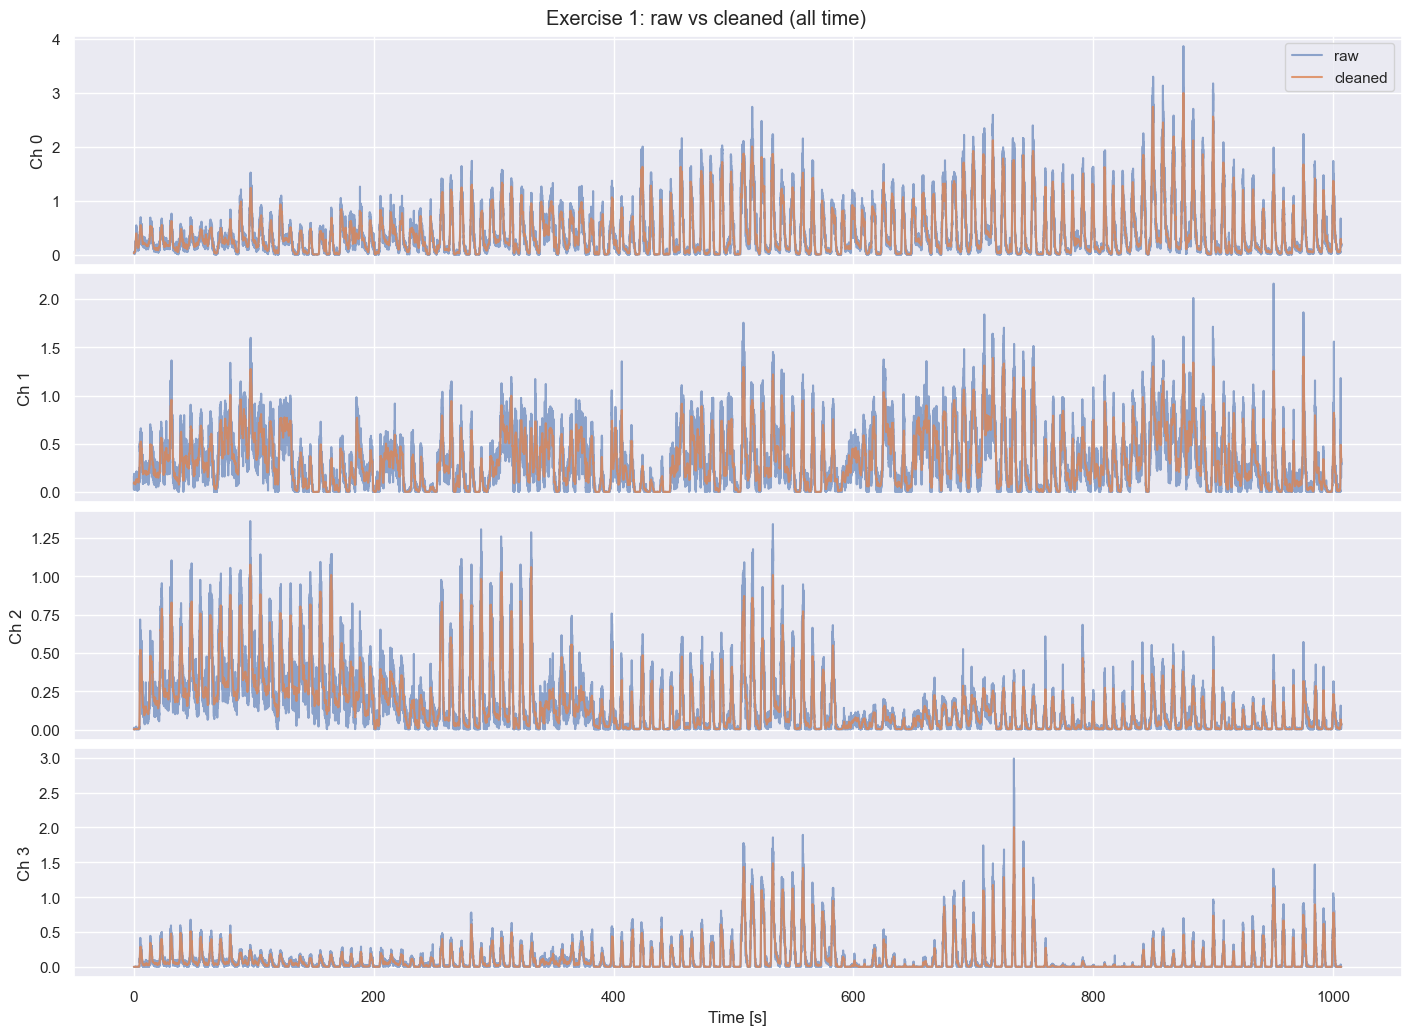

In [24]:
# Overlay raw vs cleaned (all time, first 4 channels)
raw_path = Path(EMG_DIR) / 's2' / 's2_ex1_raw.npz'
proc_path = Path(EMG_OUTPUT_DIR) / 's2' / 's2_ex1_processed.npz'
raw = np.load(raw_path)
proc = np.load(proc_path)
emg_raw = raw['emg']
emg_clean = proc['emg']
fs = float(raw['fs'])
span = emg_raw.shape[0]  # Plot all samples
channels_to_plot = min(4, emg_raw.shape[1])
t = np.arange(span) / fs

fig, axes = plt.subplots(channels_to_plot, 1, figsize=(14, 10), sharex=True, constrained_layout=True)
for i in range(channels_to_plot):
    axes[i].plot(t, emg_raw[:span, i], label='raw', alpha=0.6)
    axes[i].plot(t, emg_clean[:span, i], label='cleaned', alpha=0.8)
    axes[i].set_ylabel(f'Ch {i}')
axes[-1].set_xlabel('Time [s]')
axes[0].legend()
fig.suptitle('Exercise 1: raw vs cleaned (all time)', y=1.02)
plt.show()


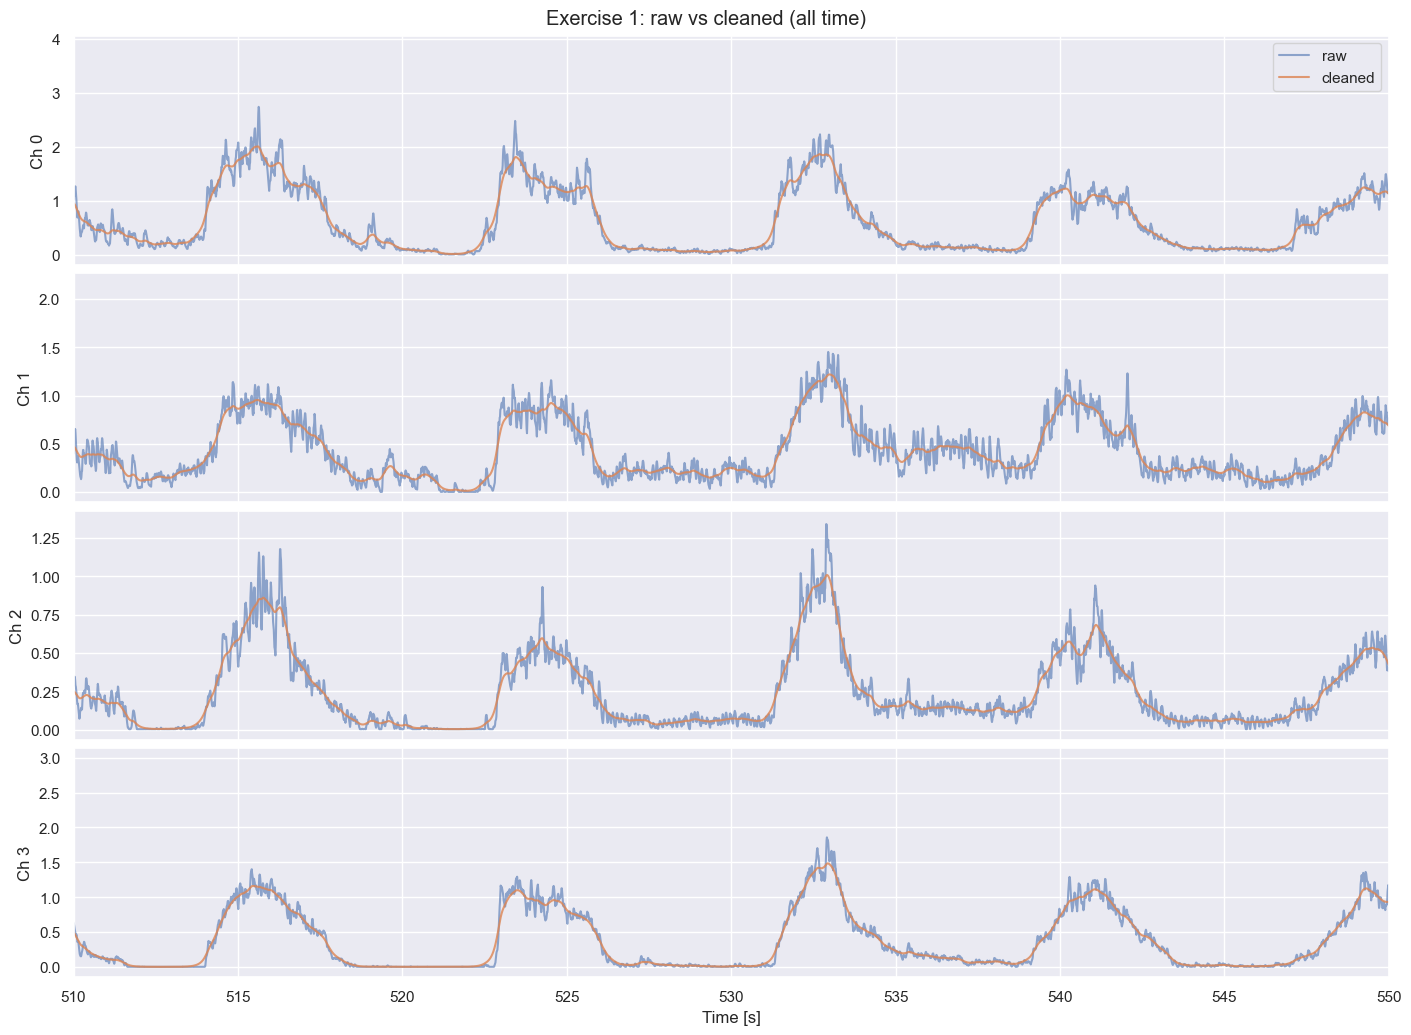

In [25]:
fig, axes = plt.subplots(channels_to_plot, 1, figsize=(14, 10), sharex=True, constrained_layout=True)
for i in range(channels_to_plot):
    axes[i].plot(t, emg_raw[:span, i], label='raw', alpha=0.6)
    axes[i].plot(t, emg_clean[:span, i], label='cleaned', alpha=0.8)  
    axes[i].set_xlim(510, 550)

    axes[i].set_ylabel(f'Ch {i}')
axes[-1].set_xlabel('Time [s]')
axes[0].legend()
fig.suptitle('Exercise 1: raw vs cleaned (all time)', y=1.02)
plt.show()

### Inspecting bad trials

In [26]:
input_path = Path(EMG_OUTPUT_DIR) / 's2' / 's2_ex1_processed.npz'
STRICT_MODE = False      
DEAD_THRESHOLD = 1e-6    
ARTIFACT_THRESHOLD = 5.0 

if not input_path.exists():
    print(f"Error: File not found at {input_path}")
else:
    data = np.load(input_path)
    emg = data['emg']
    restimulus = data['restimulus']   
    rerepetition = data['rerepetition']
    fs = data['fs']

    bad_trials_indices = []    
    movements = np.unique(restimulus)
    movements = movements[movements != 0]

    print("Scanning active trials for sensor faults...")
    for mov in movements:
        for rep in range(1, 11): 
            mask_indices = np.where((restimulus == mov) & (rerepetition == rep))[0]
            
            if len(mask_indices) == 0:
                continue
            
            trial_data = emg[mask_indices]
            
            if np.all(np.std(trial_data, axis=0) < DEAD_THRESHOLD) or \
               np.max(np.abs(trial_data)) > ARTIFACT_THRESHOLD:
                
                print(f"  Discarding Bad Trial: Mov {mov}, Rep {rep}")
                bad_trials_indices.extend(mask_indices)

    keep_mask = (restimulus != 0)
    if len(bad_trials_indices) > 0:
        keep_mask[bad_trials_indices] = False

    emg_final = emg[keep_mask]
    restimulus_final = restimulus[keep_mask]
    rerepetition_final = rerepetition[keep_mask]

    print("-" * 30)
    print(f"Original shape: {emg.shape}")
    print(f"Final shape:    {emg_final.shape} (Rest & Bad Trials removed)")

    output_path = Path(EMG_OUTPUT_DIR) / 's2' / 's2_ex1_cleaned.npz'
    np.savez(output_path, 
             emg=emg_final, 
             restimulus=restimulus_final, 
             rerepetition=rerepetition_final, 
             fs=fs)

    print(f"Saved: {output_path}")

Scanning active trials for sensor faults...
------------------------------
Original shape: (100686, 10)
Final shape:    (41791, 10) (Rest & Bad Trials removed)
Saved: c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\output\emg\s2\s2_ex1_cleaned.npz


### Visualizing average activation maps

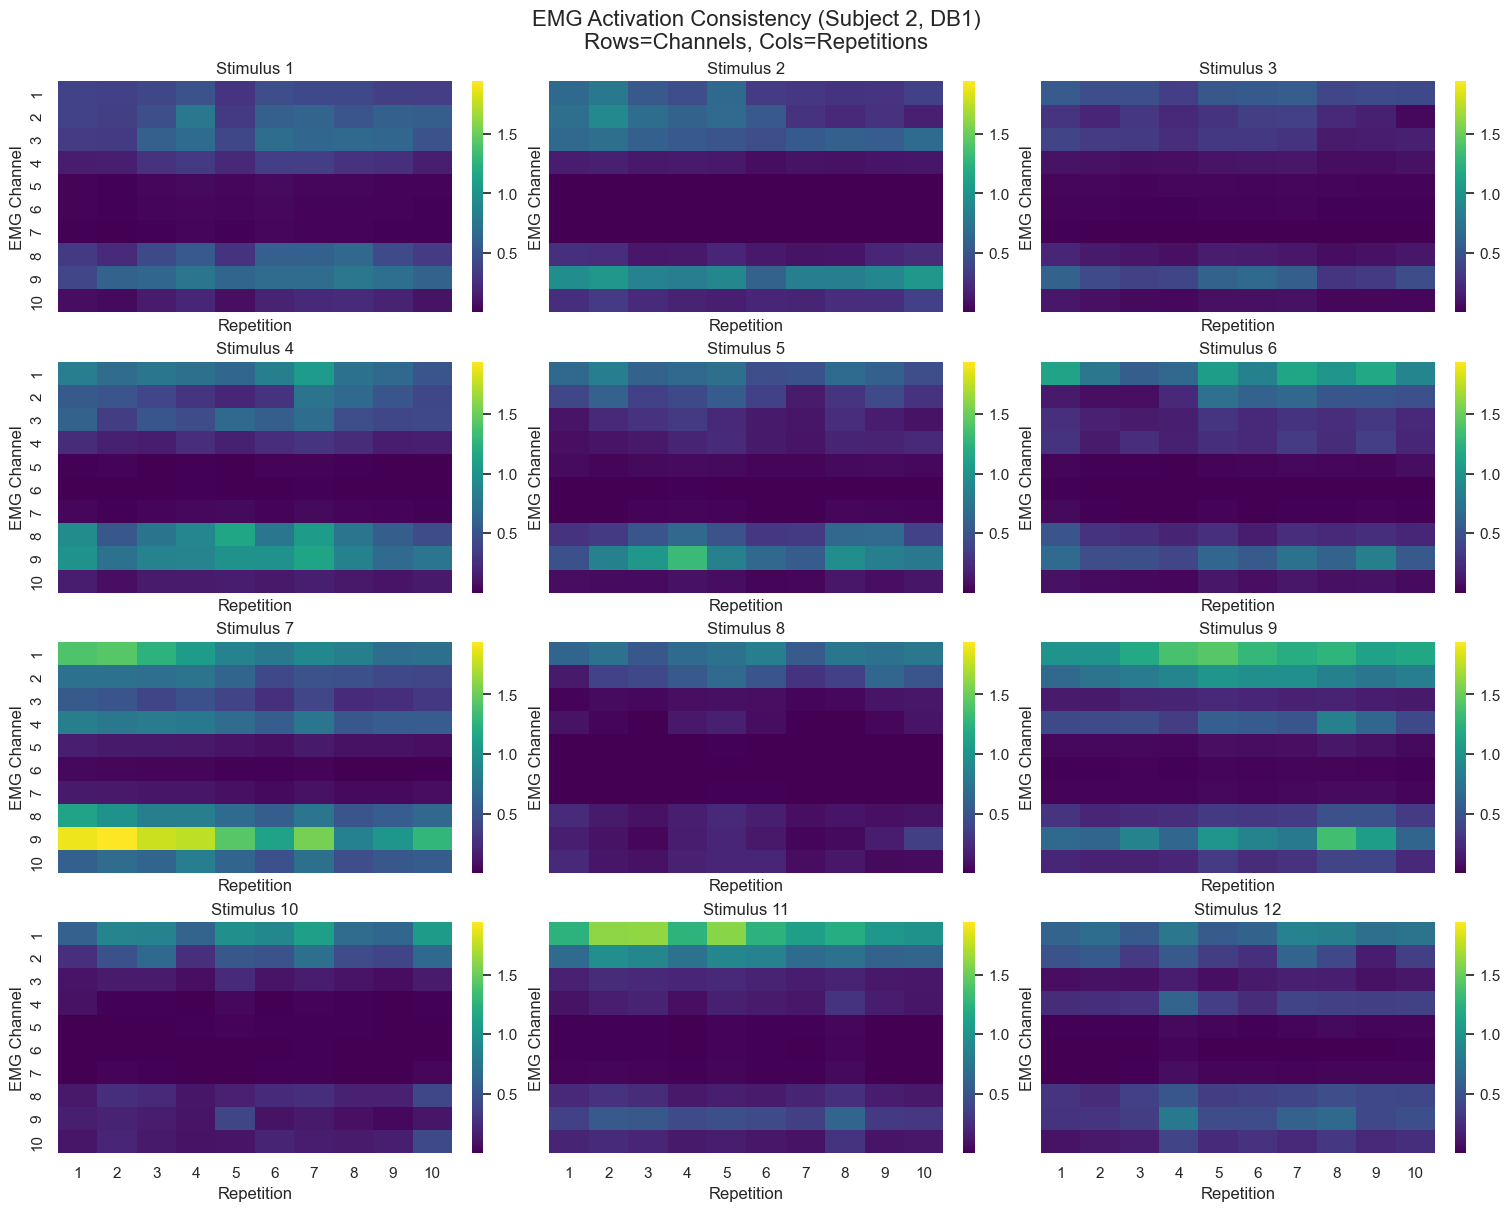

In [27]:
input_path = Path(EMG_OUTPUT_DIR) / 's2' / 's2_ex1_cleaned.npz'

data = np.load(input_path)
emg = data['emg']
stimulus = data['restimulus']
repetition = data['rerepetition']
fs = float(data['fs'])

unique_movs = np.unique(stimulus)
unique_reps = np.unique(repetition)

n_channels = emg.shape[1]
n_stimuli = len(unique_movs)
n_repetitions = len(unique_reps)

activation_matrix = np.full((n_channels, n_stimuli, n_repetitions), np.nan)

for mov_idx, mov_label in enumerate(unique_movs):
    for rep_idx, rep_label in enumerate(unique_reps):
        mask = (stimulus == mov_label) & (repetition == rep_label)
        trial_data = emg[mask]
        
        if len(trial_data) > 0:
            activation_matrix[:, mov_idx, rep_idx] = np.mean(trial_data, axis=0)

fig, ax = plt.subplots(4, 3, figsize=(15, 12), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

vmin = np.nanmin(activation_matrix)
vmax = np.nanmax(activation_matrix)

for stimuli_idx in range(n_stimuli):
    data_for_plot = activation_matrix[:, stimuli_idx, :]
    
    sns.heatmap(data_for_plot, ax=ax[stimuli_idx], 
                xticklabels=np.arange(1, 11), 
                yticklabels=np.arange(1, 11), 
                cbar=True, cmap="viridis", vmin=vmin, vmax=vmax)
    
    ax[stimuli_idx].set_title(f"Stimulus {unique_movs[stimuli_idx]}")
    ax[stimuli_idx].set_xlabel("Repetition")
    ax[stimuli_idx].set_ylabel("EMG Channel")

plt.suptitle(f"EMG Activation Consistency (Subject 2, DB1)\nRows=Channels, Cols=Repetitions", fontsize=16)
plt.show()

## Preparing datasets (split)

In [28]:
input_path = Path(EMG_OUTPUT_DIR) / 's2' / 's2_ex1_cleaned.npz'
data = np.load(input_path)

X = data['emg']
y = data['restimulus']
rep = data['rerepetition']
fs = float(data['fs'])

train_reps = [1, 3, 4, 6, 8, 9]
val_reps   = [2, 5]
test_reps  = [7, 10]

mask_train = np.isin(rep, train_reps)
mask_val   = np.isin(rep, val_reps)
mask_test  = np.isin(rep, test_reps)

X_train, y_train, rep_train = X[mask_train], y[mask_train], rep[mask_train]
X_val,   y_val,   rep_val   = X[mask_val],   y[mask_val],   rep[mask_val]
X_test,  y_test,  rep_test  = X[mask_test],  y[mask_test],  rep[mask_test]

print(f"Train samples: {len(X_train)} (Reps {train_reps})")
print(f"Val samples:   {len(X_val)}   (Reps {val_reps})")
print(f"Test samples:  {len(X_test)}  (Reps {test_reps})")

splits_path = Path(EMG_OUTPUT_DIR) / 's2' / 's2_ex1_splits.npz'
np.savez(
    splits_path,
    X_train=X_train,
    y_train=y_train,
    rep_train=rep_train,
    X_val=X_val,
    y_val=y_val,
    rep_val=rep_val,
    X_test=X_test,
    y_test=y_test,
    rep_test=rep_test,
    fs=fs
)

print(f"Saved splits to {splits_path}")

Train samples: 24993 (Reps [1, 3, 4, 6, 8, 9])
Val samples:   8753   (Reps [2, 5])
Test samples:  8045  (Reps [7, 10])
Saved splits to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\output\emg\s2\s2_ex1_splits.npz


## Selecting features

In [29]:
split_path = Path(EMG_OUTPUT_DIR) / 's2' / 's2_ex1_splits.npz'
data = np.load(split_path)

X_train_raw, y_train_raw, rep_train_raw = data['X_train'], data['y_train'], data['rep_train']
X_val_raw,   y_val_raw,   rep_val_raw   = data['X_val'],   data['y_val'],   data['rep_val']
X_test_raw,  y_test_raw,  rep_test_raw  = data['X_test'],  data['y_test'],  data['rep_test']

print(f"Raw Data Loaded. Train points: {len(X_train_raw)}")

def get_features_from_trial(window):
    wamp_thresh = 0.05 
    ssc_thresh = 0.01
    
    # 1. Standard Features
    f_mav = np.mean(np.abs(window), axis=0)
    f_rms = np.sqrt(np.mean(window**2, axis=0))
    f_wl  = np.sum(np.abs(np.diff(window, axis=0)), axis=0)
    f_var = np.var(window, axis=0)
    f_max = np.max(window, axis=0)

    # 2. Advanced Features (Boostani 2003, Sensors 2019)
    # Log Detector (LogD)
    f_logd = np.exp(np.mean(np.log(np.abs(window) + 1e-6), axis=0))
    
    # Willison Amplitude (WAMP)
    diff = np.abs(np.diff(window, axis=0))
    f_wamp = np.sum(diff > wamp_thresh, axis=0)
    
    # Slope Sign Changes (SSC)
    diff_signal = np.diff(window, axis=0)
    f_ssc = np.sum((diff_signal[:-1, :] * diff_signal[1:, :]) < -ssc_thresh, axis=0)
    
    # Histogram Stats (Skew/Kurtosis)
    f_skew = skew(window, axis=0)
    f_kurt = kurtosis(window, axis=0)
    
    # Stack: 10 features * 10 channels = 100 columns
    return np.concatenate([
        f_mav, f_rms, f_wl, f_var, f_max,  
        f_logd, f_wamp, f_ssc, f_skew, f_kurt 
    ])

def build_trial_dataset(X_data, y_data, rep_data):
    features_list = []
    labels_list = []
    
    # Find all unique Movements and Repetitions in this set
    unique_movs = np.unique(y_data)
    unique_reps = np.unique(rep_data)
    
    for mov in unique_movs:
        for rep in unique_reps:
            # Mask: Isolate ONE specific trial
            mask = (y_data == mov) & (rep_data == rep)
            trial_segment = X_data[mask]
            
            # Skip if empty (e.g. bad trial removed earlier)
            if len(trial_segment) == 0:
                continue
                
            # Collapse time dimension -> One Feature Vector
            feats = get_features_from_trial(trial_segment)
            
            features_list.append(feats)
            labels_list.append(mov)
            
    return np.array(features_list), np.array(labels_list)

print("Building Trial-Based Datasets...")
X_train, y_train = build_trial_dataset(X_train_raw, y_train_raw, rep_train_raw)
X_val,   y_val   = build_trial_dataset(X_val_raw,   y_val_raw,   rep_val_raw)
X_test,  y_test  = build_trial_dataset(X_test_raw,  y_test_raw,  rep_test_raw)

print(f"\nFinal Dataset Shapes (Samples, Features):")
print(f"Train: {X_train.shape}")
print(f"Val:   {X_val.shape}")
print(f"Test:  {X_test.shape}")

Raw Data Loaded. Train points: 24993
Building Trial-Based Datasets...

Final Dataset Shapes (Samples, Features):
Train: (72, 100)
Val:   (24, 100)
Test:  (24, 100)


### Plotting features

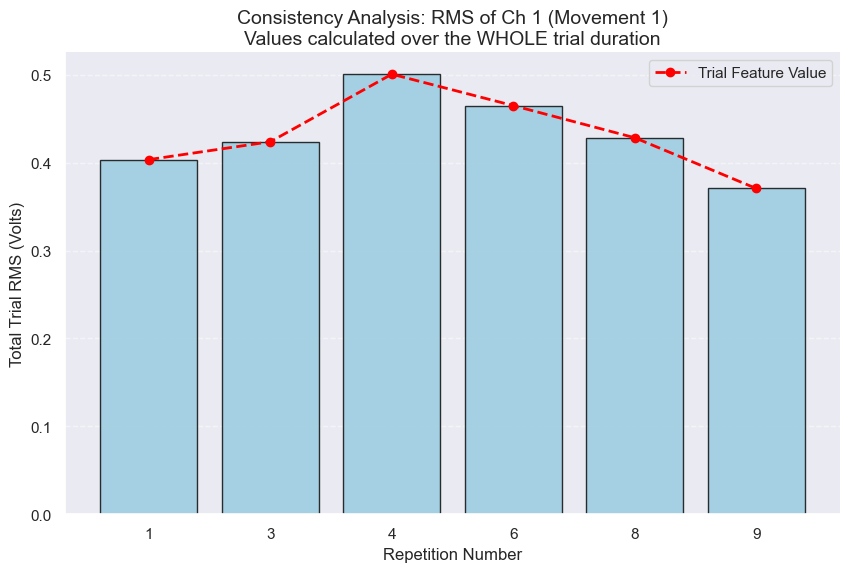

In [30]:
target_mov = 1          # Movement 1 (Index Flexion)
feature_idx = 1         # 1 = RMS (Root Mean Square)
feature_name = "RMS"
channel_idx = 0        # Channel 5 (Index 4)

plot_data = []

for rep_id in np.unique(rep_train_raw):
    mask = (y_train_raw == target_mov) & (rep_train_raw == rep_id)
    raw_segment = X_train_raw[mask]
    
    if len(raw_segment) > 0:
        feats = get_features_from_trial(raw_segment)
        
        col = (feature_idx * 10) + channel_idx
        val = feats[col]
        
        plot_data.append({
            'Repetition': str(int(rep_id)),
            'Feature Value': val
        })

df = pd.DataFrame(plot_data)

plt.figure(figsize=(10, 6))

sns.barplot(data=df, x='Repetition', y='Feature Value', 
            color='skyblue', edgecolor='black', alpha=0.8)

plt.plot(range(len(df)), df['Feature Value'], color='red', marker='o', 
         linestyle='--', linewidth=2, label='Trial Feature Value')

plt.title(f"Consistency Analysis: {feature_name} of Ch {channel_idx+1} (Movement {target_mov})\n"
          f"Values calculated over the WHOLE trial duration", fontsize=14)
plt.ylabel(f"Total Trial {feature_name} (Volts)", fontsize=12)
plt.xlabel("Repetition Number", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
sns.despine()

plt.show()

## Support Vector Machine

Starting SVM Grid Search on 96 samples...
Fitting 1 folds for each of 12 candidates, totalling 12 fits
Best Parameters: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Best Validation Accuracy: 87.50%

FINAL TEST ACCURACY: 95.83%


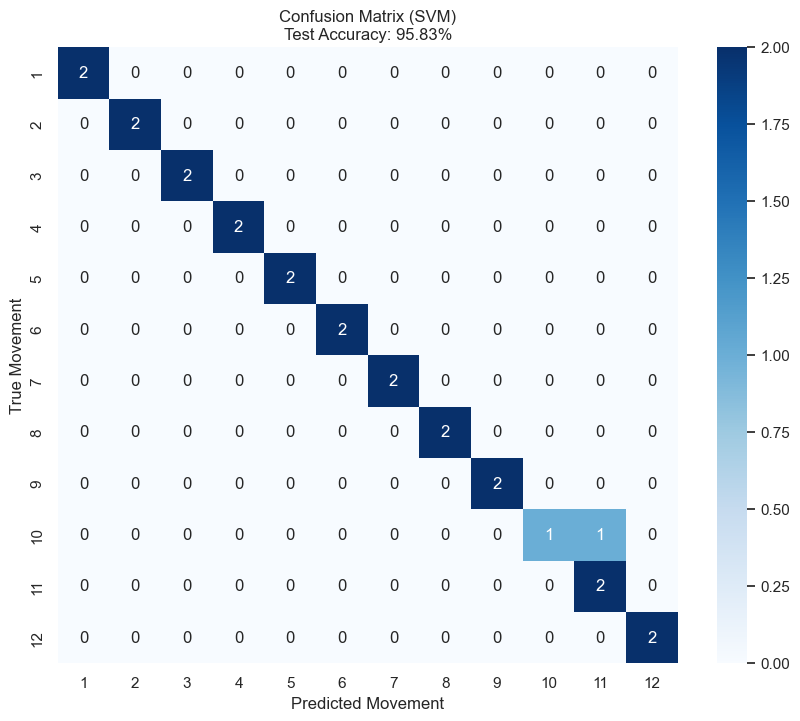

In [31]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

X_combined = np.vstack((X_train_scaled, X_val_scaled))
y_combined = np.hstack((y_train, y_val))

test_fold = np.concatenate([
    np.full(X_train_scaled.shape[0], -1),
    np.full(X_val_scaled.shape[0], 0)
])
ps = PredefinedSplit(test_fold)

param_grid = {
    'C': [0.1, 1, 10, 100],          # Regularization (Model strictness)
    'gamma': ['scale', 0.01, 0.001], # Kernel coefficient (Influence radius)
    'kernel': ['rbf']                # Radial Basis Function (Standard for EMG)
}

print(f"Starting SVM Grid Search on {len(y_combined)} samples...")
grid = GridSearchCV(
    SVC(), 
    param_grid, 
    cv=ps,               # Force use of our Val set
    scoring='accuracy', 
    verbose=1, 
    n_jobs=-1
)

grid.fit(X_combined, y_combined)

print(f"Best Parameters: {grid.best_params_}")
print(f"Best Validation Accuracy: {grid.best_score_:.2%}")

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)

print(f"\nFINAL TEST ACCURACY: {acc:.2%}")

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title(f"Confusion Matrix (SVM)\nTest Accuracy: {acc:.2%}")
plt.xlabel("Predicted Movement")
plt.ylabel("True Movement")
plt.show()

# Part 2: Generalization across subjects

## Preprocessing data

In [32]:
for i in range(1,28):
    s_num_lowercase = 's' + str(i)
    s_num_uppercase = 'S' + str(i)
    s_dir = Path(EMG_DIR) / s_num_lowercase
    
    mat_files = sorted(s_dir.glob(s_num_uppercase + '_*.mat'))
    print(f'found {len(mat_files)} .mat files for subject', s_num_lowercase)
    for f in mat_files:
        m = loadmat(f, squeeze_me=True)
        keys = [k for k in m.keys() if not k.startswith('__')]
        emg_key = next((k for k in keys if 'emg' in k.lower()), None)
        if emg_key:
            emg = m[emg_key]
        restimulus = m.get('restimulus', None)
        if restimulus is not None:
            rs = np.asarray(restimulus).ravel()
        rerepetition = m.get('rerepetition', None)
        if rerepetition is not None:
            rr = np.asarray(rerepetition).ravel()
    
    # Save only exercise 1 for subject x
    ex1_file = sorted(s_dir.glob(s_num_uppercase + '_A1_E1.mat'))
    if not ex1_file:
        raise FileNotFoundError(s_num_uppercase + '_A1_E1.mat not found under EMG_DIR/' + s_num_lowercase)
    ex1_path = ex1_file[0]
    mat_ex1 = loadmat(ex1_path, squeeze_me=True)

    subject = np.asarray(mat_ex1.get('subject')) if 'subject' in mat_ex1 else None
    exercise = np.asarray(mat_ex1.get('exercise')) if 'exercise' in mat_ex1 else None
    stimulus = np.asarray(mat_ex1.get('stimulus')) if 'stimulus' in mat_ex1 else None
    restimulus = np.asarray(mat_ex1.get('restimulus')) if 'restimulus' in mat_ex1 else None
    repetition = np.asarray(mat_ex1.get('repetition')) if 'repetition' in mat_ex1 else None
    rerepetition = np.asarray(mat_ex1.get('rerepetition')) if 'rerepetition' in mat_ex1 else None
    emg_ex1 = np.asarray(mat_ex1['emg'])
    glove = np.asarray(mat_ex1.get('glove')) if 'glove' in mat_ex1 else None
    fs_val = mat_ex1.get('fs', None)
    fs_ex1 = float(np.asarray(fs_val).squeeze()) if fs_val is not None else 100.0
    
    out_path = s_dir / (s_num_lowercase + '_ex1_raw.npz')
    np.savez(
        out_path,
        subject=subject,
        exercise=exercise,
        stimulus=stimulus,
        restimulus=restimulus,
        repetition=repetition,
        rerepetition=rerepetition,
        emg=emg_ex1,
        glove=glove,
        fs=fs_ex1,
    )
    print(f'\nsaved exercise 1 to {out_path}')

found 3 .mat files for subject s1

saved exercise 1 to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\data\EMG\s1\s1_ex1_raw.npz
found 3 .mat files for subject s2

saved exercise 1 to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\data\EMG\s2\s2_ex1_raw.npz
found 3 .mat files for subject s3

saved exercise 1 to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\data\EMG\s3\s3_ex1_raw.npz
found 3 .mat files for subject s4

saved exercise 1 to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\data\EMG\s4\s4_ex1_raw.npz
found 3 .mat files for subject s5

saved exercise 1 to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\data\EMG\s5\s5_ex1_raw.npz
found 3 .mat files for subject s6

saved exercise 1 to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\data\EMG\s6\s6_ex1_raw.npz
found 3 .mat files for subject s7

saved exercise 1 to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\data\EMG\s7\s7_ex1_raw.npz
found 3 .mat files for subject s8

saved 

### Low-pass filter at 1Hz to smooth the envelope

From paper: "Before performing the classification, the data from database 1 were preprocessed using a 1st order Butterworth low-pass filter with a 1 Hz cutoff frequency"

Processed data saved to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\output\emg\s1\s1_ex1_processed.npz
Processed data saved to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\output\emg\s2\s2_ex1_processed.npz
Processed data saved to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\output\emg\s3\s3_ex1_processed.npz
Processed data saved to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\output\emg\s4\s4_ex1_processed.npz
Processed data saved to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\output\emg\s5\s5_ex1_processed.npz
Processed data saved to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\output\emg\s6\s6_ex1_processed.npz
Processed data saved to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\output\emg\s7\s7_ex1_processed.npz
Processed data saved to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\output\emg\s8\s8_ex1_processed.npz
Processed data saved to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\output\em

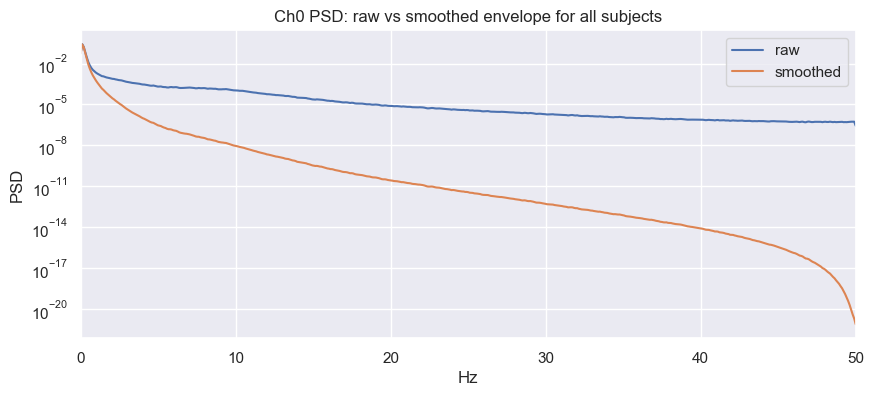

In [33]:
f_raw_all = []
pxx_raw_all = []
f_filt_all = []
pxx_filt_all = []
             
for i in range(1,28):
    s_num_lowercase = 's' + str(i)

    s_a1_e1_path = Path(EMG_DIR) / s_num_lowercase / (s_num_lowercase + '_ex1_raw.npz')
    raw = np.load(s_a1_e1_path)
    emg = raw['emg']
    fs = float(raw['fs'])  # This is 100.0
    n_channels = emg.shape[1]
    time_steps = np.arange(emg.shape[0]) / fs
    
    # plot PSD of raw vs smoothed on one plot
    f_raw, pxx_raw = welch(emg[:, 0], fs=fs, nperseg=1024)
    
    sos = butter(N=1, Wn=1, fs=fs, btype='low', output='sos')
    emg_filtered = sosfiltfilt(sos, emg.T).T
    f_filt, pxx_filt = welch(emg_filtered[:, 0], fs=fs, nperseg=1024)
    
    # 4. Save
    band_out = Path(EMG_OUTPUT_DIR) / s_num_lowercase / (s_num_lowercase + '_ex1_processed.npz')
    os.makedirs(Path(EMG_OUTPUT_DIR) / s_num_lowercase, exist_ok=True)
    np.savez(
        band_out,
        emg=emg_filtered,
        subject=raw.get('subject'),
        exercise=raw.get('exercise'),
        stimulus=raw.get('stimulus'),
        restimulus=raw.get('restimulus'),
        repetition=raw.get('repetition'),
        rerepetition=raw.get('rerepetition'),
        glove=raw.get('glove'),
        fs=fs,
    )
    print(f'Processed data saved to {band_out}')
    f_raw_all.append(f_raw)
    pxx_raw_all.append(pxx_raw)
    f_filt_all.append(f_filt)
    pxx_filt_all.append(pxx_filt)

plt.figure(figsize=(10, 4))
plt.semilogy(np.mean(np.stack(f_raw_all, axis=0), axis=0),
             np.mean(np.stack(pxx_raw_all, axis=0), axis=0), label='raw')
plt.semilogy(np.mean(np.stack(f_filt_all, axis=0), axis=0),
             np.mean(np.stack(pxx_filt_all, axis=0), axis=0), label='smoothed')
plt.xlim(0, 50)
plt.xlabel('Hz')
plt.ylabel('PSD')
plt.title('Ch0 PSD: raw vs smoothed envelope for all subjects')
plt.grid(True)
plt.legend()
plt.show()

### Inspecting Bad Trials

In [34]:
for i in range(1,28):
    s_num_lowercase = 's' + str(i)
    
    input_path = Path(EMG_OUTPUT_DIR) /  s_num_lowercase / (s_num_lowercase + '_ex1_processed.npz')
    STRICT_MODE = False      
    DEAD_THRESHOLD = 1e-6    
    ARTIFACT_THRESHOLD = 5.0 
    
    if not input_path.exists():
        print(f"Error: File not found at {input_path}")
    else:
        data = np.load(input_path)
        emg = data['emg']
        restimulus = data['restimulus']   
        rerepetition = data['rerepetition']
        fs = data['fs']
    
        bad_trials_indices = []    
        movements = np.unique(restimulus)
        movements = movements[movements != 0]
    
        print("Scanning active trials for sensor faults...")
        for mov in movements:
            for rep in range(1, 11): 
                mask_indices = np.where((restimulus == mov) & (rerepetition == rep))[0]
                
                if len(mask_indices) == 0:
                    continue
                
                trial_data = emg[mask_indices]
                
                if np.all(np.std(trial_data, axis=0) < DEAD_THRESHOLD) or \
                   np.max(np.abs(trial_data)) > ARTIFACT_THRESHOLD:
                    
                    print(f"  Discarding Bad Trial: Mov {mov}, Rep {rep}")
                    bad_trials_indices.extend(mask_indices)
    
        keep_mask = (restimulus != 0)
        if len(bad_trials_indices) > 0:
            keep_mask[bad_trials_indices] = False
    
        emg_final = emg[keep_mask]
        restimulus_final = restimulus[keep_mask]
        rerepetition_final = rerepetition[keep_mask]
    
        print("-" * 30)
        print(f"Original shape: {emg.shape}")
        print(f"Final shape:    {emg_final.shape} (Rest & Bad Trials removed)")
    
        output_path = Path(EMG_OUTPUT_DIR) / s_num_lowercase / (s_num_lowercase + '_ex1_cleaned.npz')
        np.savez(output_path, 
                 emg=emg_final, 
                 restimulus=restimulus_final, 
                 rerepetition=rerepetition_final, 
                 fs=fs)
    
        print(f"Saved: {output_path}")

Scanning active trials for sensor faults...
------------------------------
Original shape: (101014, 10)
Final shape:    (37700, 10) (Rest & Bad Trials removed)
Saved: c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\output\emg\s1\s1_ex1_cleaned.npz
Scanning active trials for sensor faults...
------------------------------
Original shape: (100686, 10)
Final shape:    (41791, 10) (Rest & Bad Trials removed)
Saved: c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\output\emg\s2\s2_ex1_cleaned.npz
Scanning active trials for sensor faults...
------------------------------
Original shape: (100720, 10)
Final shape:    (38274, 10) (Rest & Bad Trials removed)
Saved: c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\output\emg\s3\s3_ex1_cleaned.npz
Scanning active trials for sensor faults...
------------------------------
Original shape: (100835, 10)
Final shape:    (46569, 10) (Rest & Bad Trials removed)
Saved: c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\output\emg\s4

### Visualizing average activation maps

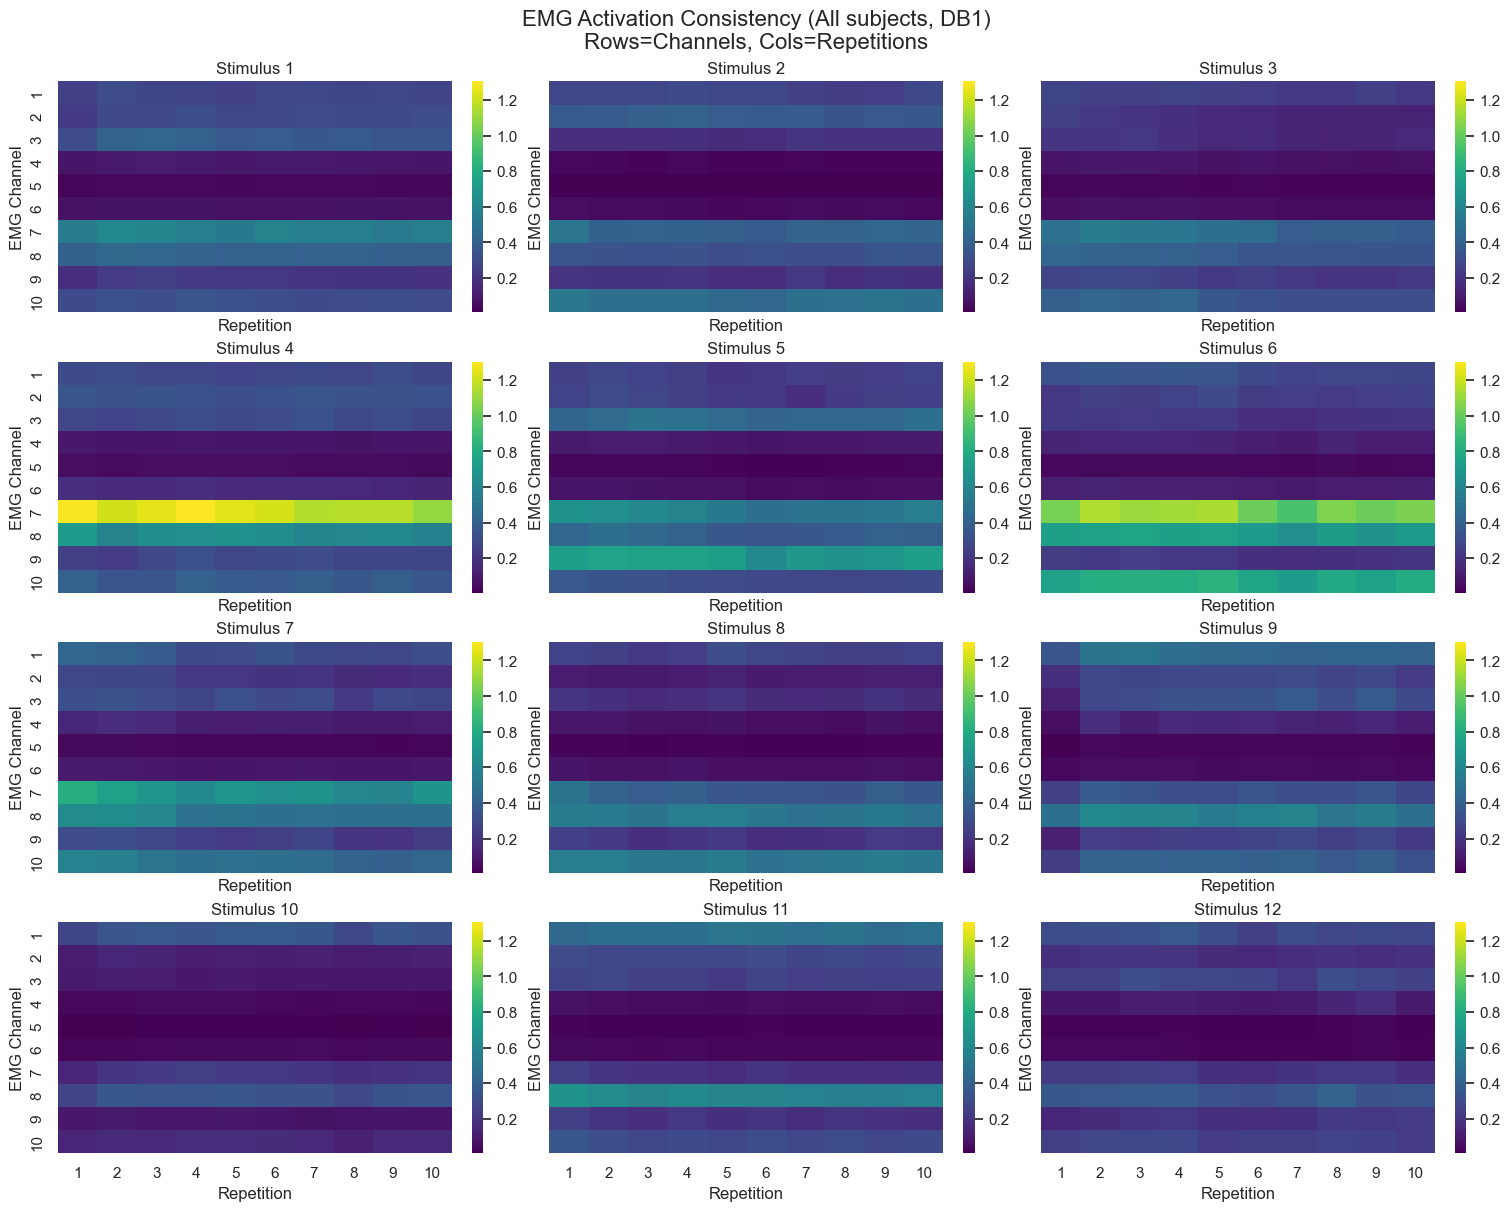

In [35]:
dataset = []
for subject in range(1,28):
    s_num_lowercase = 's' + str(subject)
    
    input_path = Path(EMG_OUTPUT_DIR) / s_num_lowercase / (s_num_lowercase + '_ex1_cleaned.npz')
    
    data = np.load(input_path)
    emg = data['emg']
    stimulus = data['restimulus']
    repetition = data['rerepetition']
    fs = float(data['fs'])
    
    unique_movs = np.unique(stimulus)
    unique_reps = np.unique(repetition)
    
    n_channels = emg.shape[1]
    n_stimuli = len(unique_movs)
    n_repetitions = len(unique_reps)
    
    activation_matrix = np.full((n_channels, n_stimuli, n_repetitions), np.nan)
    
    for mov_idx, mov_label in enumerate(unique_movs):
        for rep_idx, rep_label in enumerate(unique_reps):
            mask = (stimulus == mov_label) & (repetition == rep_label)
            trial_data = emg[mask]
            
            if len(trial_data) > 0:
                activation_matrix[:, mov_idx, rep_idx] = np.mean(trial_data, axis=0)
    
    dataset.append(activation_matrix)

avg = np.mean(np.stack(dataset, axis=0), axis=0)

fig, ax = plt.subplots(4, 3, figsize=(15, 12), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

vmin = np.nanmin(avg)
vmax = np.nanmax(avg)

for stimuli_idx in range(n_stimuli):
    data_for_plot = avg[:, stimuli_idx, :]
    
    sns.heatmap(data_for_plot, ax=ax[stimuli_idx], 
                xticklabels=np.arange(1, 11), 
                yticklabels=np.arange(1, 11), 
                cbar=True, cmap="viridis", vmin=vmin, vmax=vmax)
    
    ax[stimuli_idx].set_title(f"Stimulus {unique_movs[stimuli_idx]}")
    ax[stimuli_idx].set_xlabel("Repetition")
    ax[stimuli_idx].set_ylabel("EMG Channel")

plt.suptitle(f"EMG Activation Consistency (All subjects, DB1)\nRows=Channels, Cols=Repetitions", fontsize=16)
plt.show()

### Feature extraction

2. Extract the same set of features. Now look at the values of those features across the  
different subjects. Are there any similarity/discrepancies between the subjects?  

In [ ]:
def get_features_from_trial(window):
    wamp_thresh = 0.05 
    ssc_thresh = 0.01
    
    # 1. Standard Features
    f_mav = np.mean(np.abs(window), axis=0)
    f_rms = np.sqrt(np.mean(window**2, axis=0))
    f_wl  = np.sum(np.abs(np.diff(window, axis=0)), axis=0)
    f_var = np.var(window, axis=0)
    f_max = np.max(window, axis=0)

    # 2. Advanced Features (Boostani 2003, Sensors 2019)
    # Log Detector (LogD)
    f_logd = np.exp(np.mean(np.log(np.abs(window) + 1e-6), axis=0))
    
    # Willison Amplitude (WAMP)
    diff = np.abs(np.diff(window, axis=0))
    f_wamp = np.sum(diff > wamp_thresh, axis=0)
    
    # Slope Sign Changes (SSC)
    diff_signal = np.diff(window, axis=0)
    f_ssc = np.sum((diff_signal[:-1, :] * diff_signal[1:, :]) < -ssc_thresh, axis=0)
    
    # Histogram Stats (Skew/Kurtosis)
    f_skew = skew(window, axis=0)
    f_kurt = kurtosis(window, axis=0)
    
    # Stack: 10 features * 10 channels = 100 columns
    return np.concatenate([
        f_mav, f_rms, f_wl, f_var, f_max,  
        f_logd, f_wamp, f_ssc, f_skew, f_kurt 
    ])

In [51]:
dataset = []

for subject in range(1, 28):
    s = f"s{subject}"
    input_path = Path(EMG_OUTPUT_DIR) / s / f"{s}_ex1_cleaned.npz"
    data = np.load(input_path)

    emg        = data["emg"]          # (T, n_channels)
    stimulus   = data["restimulus"]   # (T,)
    repetition = data["rerepetition"] # (T,)

    dataset.append({
        "subject": subject,
        "emg": emg,
        "stimulus": stimulus,
        "repetition": repetition,
    })


In [65]:
dataset

[{'subject': 1,
  'emg': array([[0.03050273, 0.02203962, 0.00827844, ..., 0.04844453, 0.0107376 ,
          0.00797354],
         [0.03055446, 0.02327808, 0.00865819, ..., 0.04891615, 0.01127829,
          0.00806523],
         [0.03066187, 0.02452653, 0.0090627 , ..., 0.04944843, 0.01185408,
          0.00813108],
         ...,
         [0.00314305, 0.01649317, 0.00249136, ..., 0.04039657, 0.00464725,
          0.01373166],
         [0.0031177 , 0.01564125, 0.00248815, ..., 0.03993984, 0.0045103 ,
          0.01375389],
         [0.00309518, 0.01483437, 0.00248529, ..., 0.03950837, 0.00438171,
          0.01376536]]),
  'stimulus': array([ 1,  1,  1, ..., 12, 12, 12], dtype=uint8),
  'repetition': array([ 1,  1,  1, ..., 10, 10, 10], dtype=uint8),
  'X_features': array([[ 3.17296228e-02,  2.50226000e-02,  3.83964578e-02, ...,
          -8.24135000e-01, -8.54127369e-01,  2.33901904e+00],
         [ 6.17654382e-02,  1.06589629e-01,  1.71121683e-02, ...,
           4.77217757e-01, -1.304

In [ ]:
def extract_subject_features(emg, stimulus, repetition, skip_rest=True):
    X = []
    y = []
    rep_ids = []

    unique_movs = np.unique(stimulus)
    unique_reps = np.unique(repetition)

    for mov in unique_movs:
        if skip_rest and mov == 0:
            continue
        for rep in unique_reps:
            mask = (stimulus == mov) & (repetition == rep)
            seg = emg[mask]
            if seg.size == 0:
                continue

            feats = get_features_from_trial(seg)
            X.append(feats)
            y.append(mov)
            rep_ids.append(rep)

    return np.array(X), np.array(y), np.array(rep_ids)

In [58]:
for subj in dataset:
    emg  = subj["emg"]
    stim = subj["stimulus"]
    rep  = subj["repetition"]

    X_s, y_s, rep_s = extract_subject_features(emg, stim, rep)

    subj["X_features"] = X_s      # (n_trials_subject, n_features)
    subj["y_labels"]   = y_s      # movement id per trial
    subj["rep_ids"]    = rep_s    # repetition per trial


C:\Users\rokas\AppData\Local\Temp\ipykernel_24008\3303627949.py:25: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  f_skew = skew(window, axis=0)
C:\Users\rokas\AppData\Local\Temp\ipykernel_24008\3303627949.py:26: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  f_kurt = kurtosis(window, axis=0)


In [61]:
dataset[0].keys()

dict_keys(['subject', 'emg', 'stimulus', 'repetition', 'X_features', 'y_labels', 'rep_ids'])

In [64]:
dataset[0]['X_features'].shape()

TypeError: 'tuple' object is not callable